# Land-Cover Classification Using K-Means Clustering  

This notebook demonstrates:  
- Loading a multi-band GeoTIFF (RGB + alpha)  
- Inspecting individual bands and RGB composite  
- Determining the optimal number of clusters via Elbow method  
- Performing K-Means clustering on the spectral 
- Interpretation, Lessons Learnt and Future Scope

## 1. Setup & Imports

In [1]:
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Enable GDAL exceptions and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

# Inline plotting
%matplotlib inline

# 2. Load Raster & Inspect Bands

Opening the GeoTIFF and checking band count and color interpretations. For this notebook, I connected Google Satellite with QGIS and exported the layer as **.tif**. The .tif file corresponds to the SVNIT campus of Surat City located in Southern Gujarat region of India.

In [2]:
# Path to the downloaded GeoTIFF
tif_path = 'surat.tif'
ds = gdal.Open(tif_path, gdal.GA_ReadOnly)

rows, cols = ds.RasterYSize, ds.RasterXSize
n_bands = ds.RasterCount

print(f"Raster dimensions: {cols} × {rows}")
print(f"Number of bands: {n_bands}")

# Display color interpretation and description for each band
for i in range(1, n_bands + 1):
    band = ds.GetRasterBand(i)
    ci = gdal.GetColorInterpretationName(band.GetColorInterpretation())
    desc = band.GetDescription() or '–'
    print(f"Band {i}: ColorInterp={ci}")

Raster dimensions: 2297 × 1831
Number of bands: 4
Band 1: ColorInterp=Red
Band 2: ColorInterp=Green
Band 3: ColorInterp=Blue
Band 4: ColorInterp=Alpha


## 3. Single-Band Visualization (Grayscale)

Displaying Band 1 in grayscale.

(-0.5, 2296.5, 1830.5, -0.5)

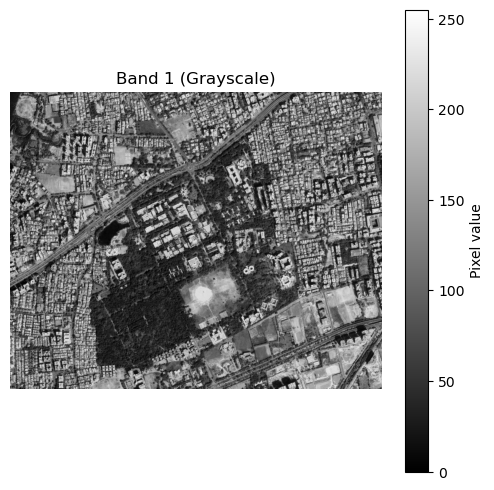

In [3]:
band1 = ds.GetRasterBand(1).ReadAsArray()

plt.figure(figsize=(6,6))
plt.title('Band 1 (Grayscale)')
plt.imshow(band1, cmap='gray')
plt.colorbar(label='Pixel value')
plt.axis('off')

## 4. True-Color Composite
Stacking Bands 1–3 as R, G, B and normalizing for display.

(-0.5, 2296.5, 1830.5, -0.5)

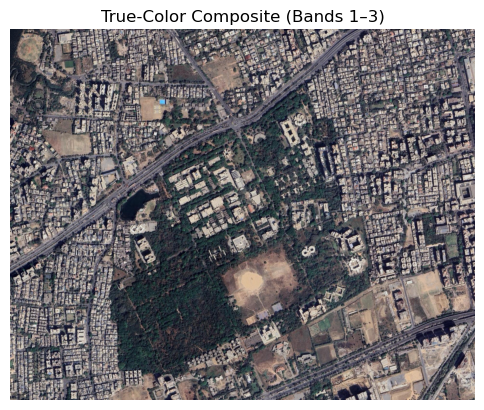

In [4]:
r = ds.GetRasterBand(1).ReadAsArray().astype('float32')
g = ds.GetRasterBand(2).ReadAsArray().astype('float32')
b = ds.GetRasterBand(3).ReadAsArray().astype('float32')

rgb = np.dstack([r, g, b])
rgb -= rgb.min()
rgb /= rgb.max()

plt.figure(figsize=(6,6))
plt.title('True-Color Composite (Bands 1–3)')
plt.imshow(rgb)
plt.axis('off')


## 5. Data Preparation for Clustering
Flattening the spatial cube into a 2D matrix of pixels × bands.

In [5]:
nb = 3  # using only R, G, B bands
dtype = gdal_array.GDALTypeCodeToNumericTypeCode(
    ds.GetRasterBand(1).DataType)

# Allocate array and fill with band data
img = np.zeros((rows, cols, nb), dtype=dtype)
for i in range(nb):
    img[:,:,i] = ds.GetRasterBand(i+1).ReadAsArray()

# Reshape to (n_pixels, n_features)
X = img.reshape((-1, nb))
print("Shape for clustering:", X.shape)


Shape for clustering: (4205807, 3)


## 6. Determining Optimal k
Elbow analyses was performed to find the optimal value of k

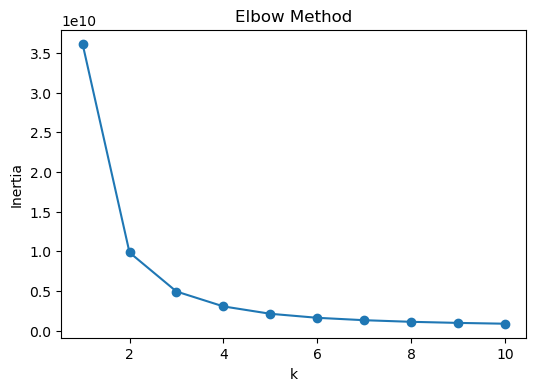

In [6]:
ks = range(1, 11)
inertias = []
sil_scores = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=0).fit(X)
    inertias.append(km.inertia_)

# Elbow plot
plt.figure(figsize=(6,4))
plt.plot(ks, inertias, '-o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()



Lets take k=4

## 7. K-Means Clustering (k = 4)
Clustering on the full dataset using the chosen k.

In [7]:
k = 4
km = KMeans(n_clusters=k, random_state=42).fit(X)
labels = km.labels_.reshape((rows, cols))

print("Cluster centers (mean R, G, B):")
print(np.round(km.cluster_centers_, 1))

Cluster centers (mean R, G, B):
[[ 85.3  83.2  88. ]
 [141.3 131.2 130.3]
 [ 35.9  39.   48.5]
 [193.8 183.  176.4]]


## 8. Cluster Map Visualization
Mapping each cluster to a custom RGB colormap: red, green, blue.

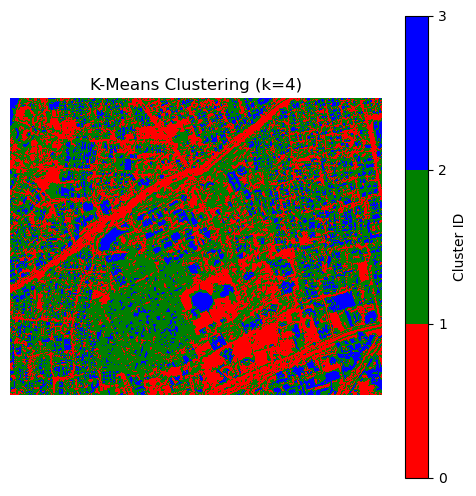

In [8]:
from matplotlib.colors import ListedColormap

# Custom colormap for clusters 0→red, 1→green, 2→blue
cmap3 = ListedColormap(['red', 'green', 'blue'])

plt.figure(figsize=(6,6))
plt.imshow(labels, cmap=cmap3, vmin=0, vmax=k-1)
plt.title(f'K-Means Clustering (k={k})')
plt.axis('off')
plt.colorbar(ticks=range(k), label='Cluster ID')
plt.show()

**Interpretation**
- It was able to correctly map green spaces from the map. For instance: The big green patch corresponds the green space of SVNIT Campus area.
- Also, it was also able to segregate the green cover from gardens and adjacent roads.
- However, it struggled with clustering open spaces, buildings with water bodies. For example: The cricket ground (open space) and the Lake Garden (water body) was grouped in same cluster. No matter how much value of k was adjusted, it struggled to differentiate it. 

**Lessons Learnt**  
- Clustering on RGB can separate land-cover types but can confuse spectrally similar features (e.g., bare ground vs.water bodies).    
- Elbow analys is important in proving quantitative guidance for selecting k.  
- Inspection of cluster centers is required to assign meaningful land-cover labels.
- More fine tuning and land use DL models are important for such land classification tasks.

**Future Scope**  
- Incorporation of NIR/SWIR bands (e.g., Sentinel-2) for improved vegetation and water discrimination, including NDVI computation.  
- Exploration of advanced clustering algorithms (GMM, DBSCAN) to capture non-spherical or density-based data.  
- Investigation of deep-learning approaches (e.g., U-Net) for pixel-level semantic segmentation.
